<a href="https://colab.research.google.com/github/Imartinezcuevas/k_brazos_MC_OL/blob/main/bandit_experiment_ucb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos de UCB en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos de Ascenso del gradiente en un problema de k-armed bandit.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción
En este experimento, nos centraremos en dos algoritmos populares para resolver el problema del bandido de k-brazos: UCB1 y UCB2. Ambos pertenecen a la familia de algoritmos Upper Confidence Bound (UCB), que utilizan límites de confianza superiores para guiar la toma de decisiones. UCB1 es un algoritmo simple y efectivo que ha demostrado un rendimiento sólido. UCB2, por otro lado, introduce un parámetro α que permite un control más fino del equilibrio entre exploración y explotación.

Nuestro objetivo principal es comparar el rendimiento de UCB1 y UCB2 en diferentes escenarios. Para ello, realizaremos una serie de experimentos variando parámetros clave como el número de brazos (k), la distribución de recompensas y, en el caso de UCB2, el parámetro α. Mediremos y compararemos el arrepentimiento acumulado, el porcentaje de selecciones óptimas y las recompensas promedio obtenidas por cada algoritmo

## Preparación del entorno

In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/k_brazos_MC_OL.git
!cd k_brazos_MC_OL/

Cloning into 'k_brazos_MC_OL'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 204 (delta 107), reused 129 (delta 51), pack-reused 0 (from 0)
Receiving objects: 100% (204/204), 12.55 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_MC_OL/src']


## Bucle experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [8]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    # Para almacenar selecciones y recompensas promedio de cada brazo por algoritmo
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Número de selecciones por brazo
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Suma de recompensas por brazo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)
        # Obtener la recompensa esperada óptima.
        optimal_reward = current_bandit.pull_arm(optimal_arm)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                #regrets[idx, step] = optimal_reward*step - total_rewards_per_algo[idx] # Acumular el regret en la matriz regrets para el algoritmo idx en el paso step.

                if step == 0:
                    regrets[idx, step] = optimal_reward - reward  # Primer paso
                else:
                    regrets[idx, step] = regrets[idx, step - 1] + (optimal_reward - reward)

                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm",
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Registrar número de selecciones y recompensas por brazo
                arm_counts[idx, chosen_arm] += 1
                arm_rewards[idx, chosen_arm] += reward


    rewards /= runs
    regrets /= runs  # Calcular el promedio del regret acumulado
    arm_avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts != 0)
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    return rewards, optimal_selections, regrets, arm_counts, arm_avg_rewards

Para calcular el regret con la fórmula de las diapositivas sería: $\text{regrets}[idx, step] = \text{optimal_reward} \times step - \text{total_rewards_per_algo}[idx]$.

Estamos multiplicando la recompensa óptima de un solo paso por el número de pasos (step), pero esto no necesariamente representa la suma de todas las recompensas óptimas acumuladas hasta ese momento. Si en un experimento el algoritmo obtiene una recompensa mayor de lo esperado en algún paso, el regret podría disminuir artificialmente.

Vamos a cambiarlo a $\text{regrets}[idx, step] = \text{regrets}[idx, step - 1] + (\text{optimal_reward} - \text{reward})$ para asegurar que el regret solo aumenta o se mantiene estable.

# Análisis individual
El objetivo de este estudio es aislar y analizar la influencia de los parámetros en el rendimiento de los algoritmos. Para lograr esto, hemos decidido fijar otros parámetros relevantes del experimento, asegurando así que las variaciones en los resultados se deban exclusivamente a los cambios en los parámetros.

Pero como sabemos UCB1 no tiene parámetros, por lo que probaremos los dos algoritmos al mismo tiempo. Variando alpha en UCB2 para ver con cual obtenemos mejores resultado.

* **Parámetros Fijos**

  * Número de brazos (k): Se establecerá en 10.
  * Distribución de recompensas: Se utilizará una distribución normal. Despues utilizaremos las distribuciones binomial y de Bernoulli.
  * Número de pasos (steps): Cada ejecución del algoritmo constará de 1000 pasos.
  * Número de ejecuciones (runs): Se realizarán 500 ejecuciones independientes del experimento.

In [9]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), UCB2(k=k, alpha=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Recompensa promedio

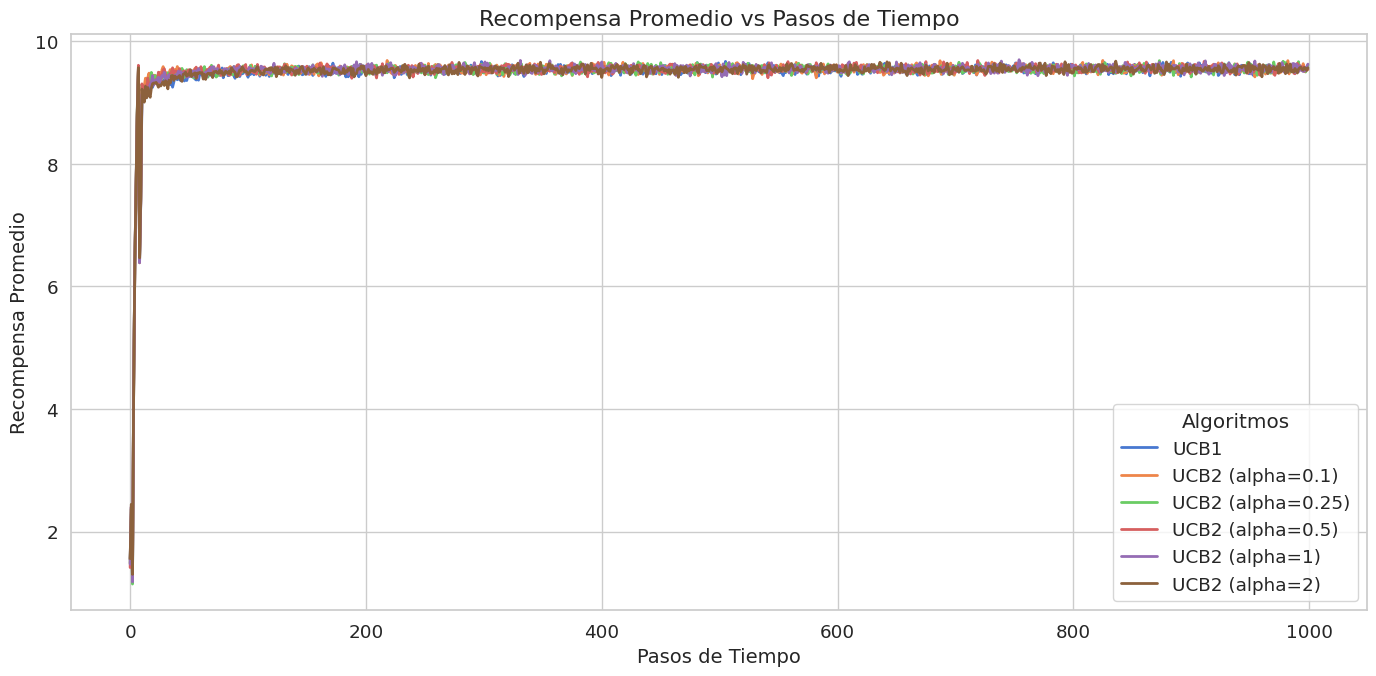

In [10]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

1. **Crecimiento rápido al inicio**
  * Todos los algoritmos muestran un rápido crecimiento en la recompensa promedio en los primeros pasos de tiempo, indicando una fase inicial de exploración y aprendizaje.
2. **Diferencias entre UCB1 y UCB2**
  * A simple vista, todas las variantes de UCB2 tienen un desempeño muy similar a UCB1, lo que sugiere que la elección de α no impacta significativamente la recompensa promedio en este caso.
3. **Efecto del parámetro α en UCB2**
  * Las líneas de UCB2 con distintos α son casi indistinguibles. Es posible que en otros escenarios, como con mayor número de brazos podamos ver mejor la diferencia.

En este escenario no podemos ver una diferencia significativa entre UCB1 y UCB2. Para evaluar mejor su efecto, vamos a probar diferentes escenarios: aumentar el numero de brazos y comparar entre distribuciones.

### Regret acumulado

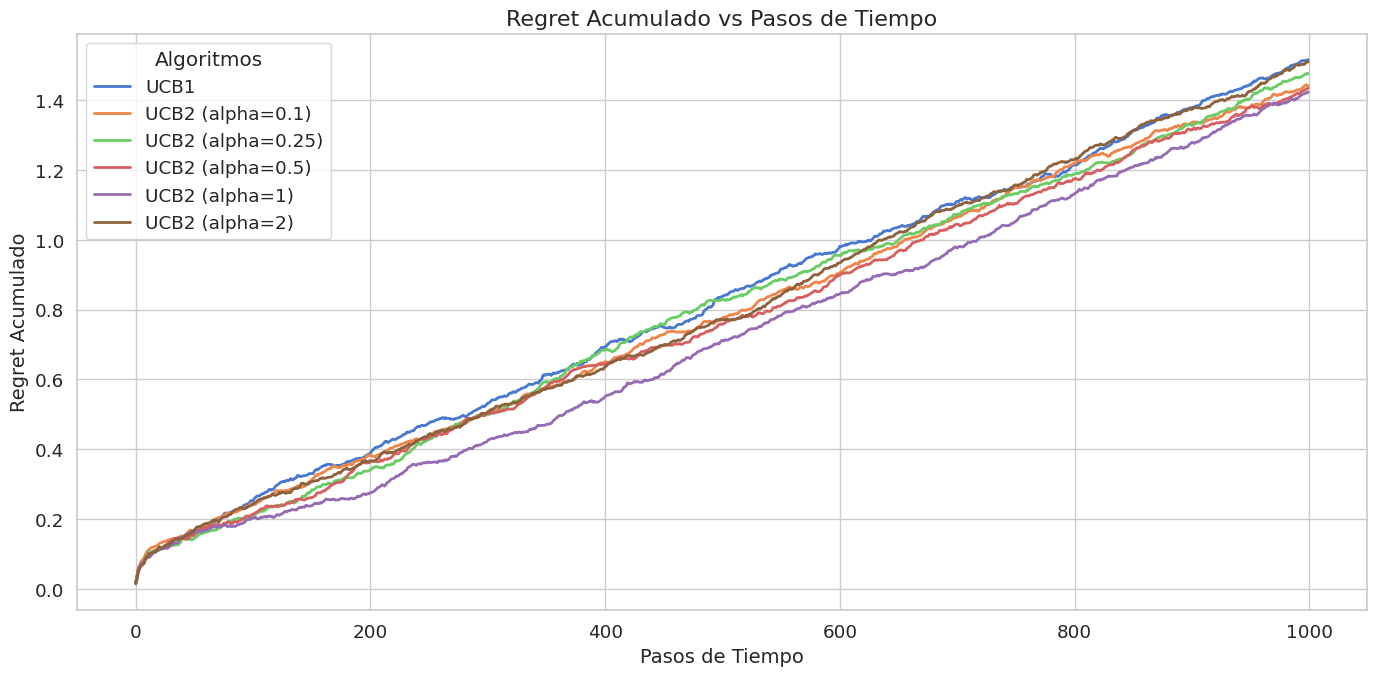

In [11]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

1. **Comportamiento general**
  * En general, se aprecia que el regret acumulado se mantiene relativamente bajo (cercano al rango de 1.0-1.4 al final de la simulación), lo que indica que los algoritmos están eligiendo con bastante frecuencia el mejor brazo o, al menos, alguno de los brazos de alto rendimiento.
2. **Comparación entre UCB1 y UCB2**
  * UCB1 (línea azul) y las variantes de UCB2 exhiben trayectorias bastante similares, sin diferencias muy pronunciadas. Pequeñas variaciones en la pendiente de cada curva pueden indicar momentos en que un algoritmo explora más que otro. Sin embargo, no se observa un claro ganador a simple vista. Podríamos decir que UCB2 con α = 1 sería el mejor.

  En conjunto, los resultados muestran que UCB1 y las variantes de UCB2 tienen un rendimiento muy similar en términos de regret acumulado.

### Porcentaje de selección del brazo óptimo

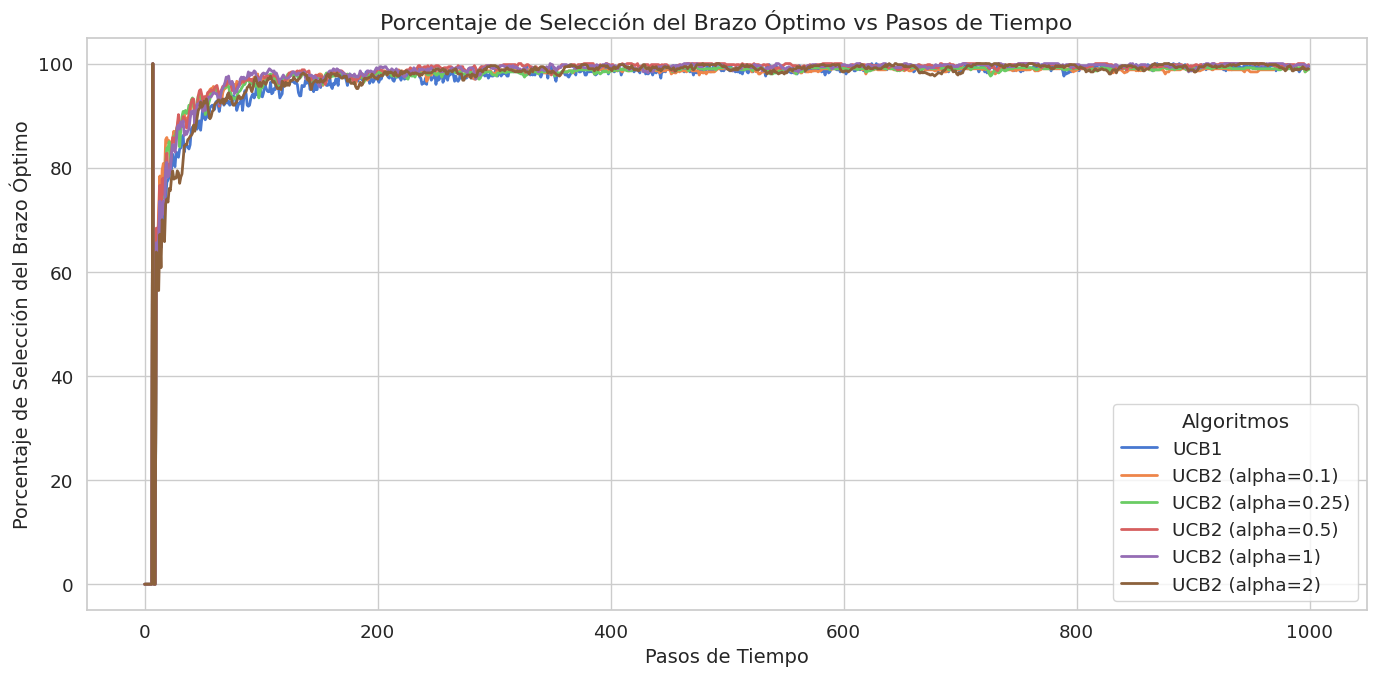

In [12]:
plot_optimal_selections(steps, optimal_selections, algorithms)

La imagen muestra un gráfico de líneas titulado "Porcentaje de selección del brazo óptimo vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

1. **Inicio**
  * Podemos observar que al inicio los algoritmos con α más alto seleccionan menos el brazo óptimo. Pero rapidamente todos convergen a eligir el brazo optimo un 100% o casi.



# Análisis comparativo

## Comparación entre número de brazos
Como hemos observado que todas las pruebas obtienen unos resultados muy similares. Vamos a estudiar los algoritmos en diferentes niveles de complejidad. Para ello en este apartado se estudiará como el número de brazos afecta en la capacidad de convergencia y la eficiencia de ambos algoritmos.

Los objetivos son:
* Determinar como el rendimiento de los algoritmos se ve afectado al aumentar el número de brazos.
* Observar como la velocidad de convergencia varía en función del número de brazos.

Se realizarán experimentos variando el número de brazos en el siguiente rango $[15, 30]$.

#### K = 15

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 15  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), UCB2(k=k, alpha=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 15 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

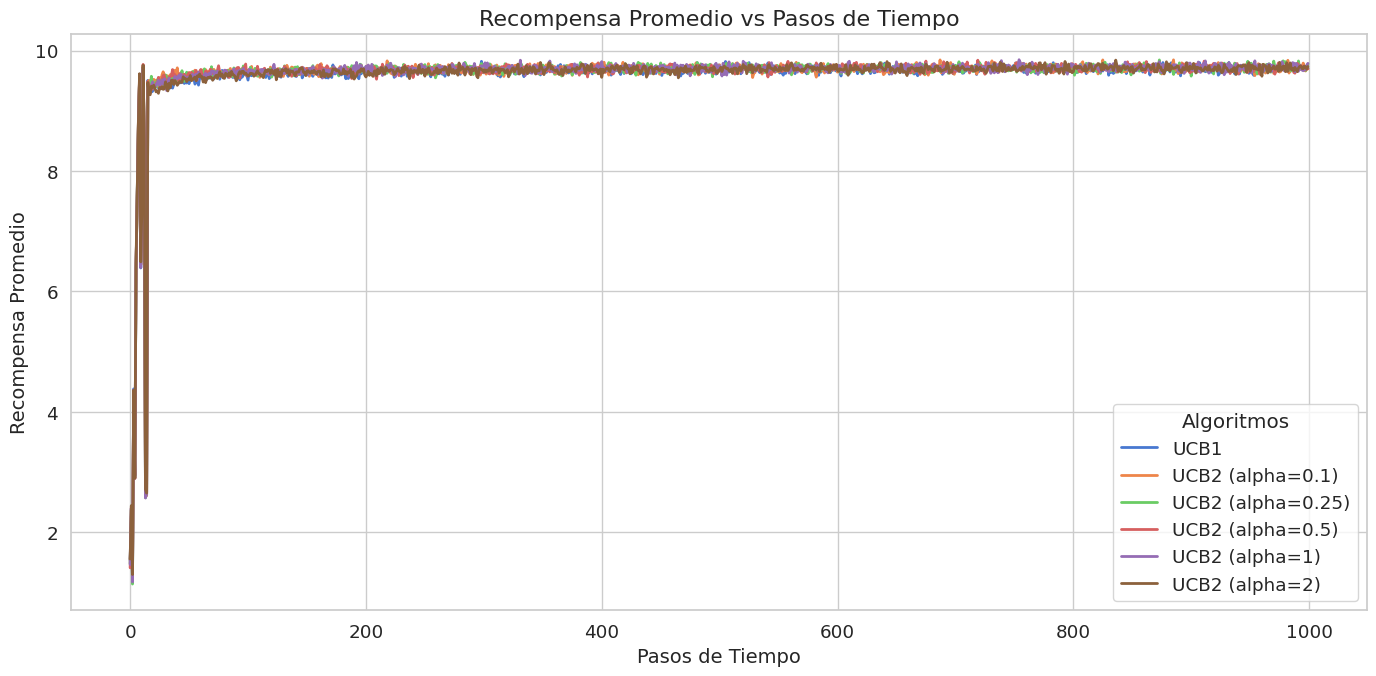

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

En este nuevo gráfico de "Recompensa Promedio vs Pasos de Tiempo" con 15 brazos, observamos lo siguiente:

1. **Comportamiento General**
  * En los primeros pasos, las recompensas varían significativamente, lo cual es esperable debido a la fase de exploración inicial.
  * Las curvas de los distintos algoritmos son prácticamente indistinguibles, lo que sugiere que, a pesar del aumento en la cantidad de brazos, tanto UCB1 como UCB2 (con distintos valores de α) convergen a desempeños similares.

2. **Impacto del Aumento de Brazos**
  * A diferencia del caso con menos brazos, donde la exploración podía haber sido más eficiente, ahora los algoritmos deben probar más opciones antes de converger a una buena política.

3. **Comparación con el Caso de Menos Brazos**
  * En ambos casos, las recompensas promedio convergen rápidamente a valores altos.

El aumento a 15 brazos no generó diferencias significativas en el desempeño de UCB1 y UCB2. Todos los algoritmos convergen a una recompensa alta y estable.


##### Regret acumulado

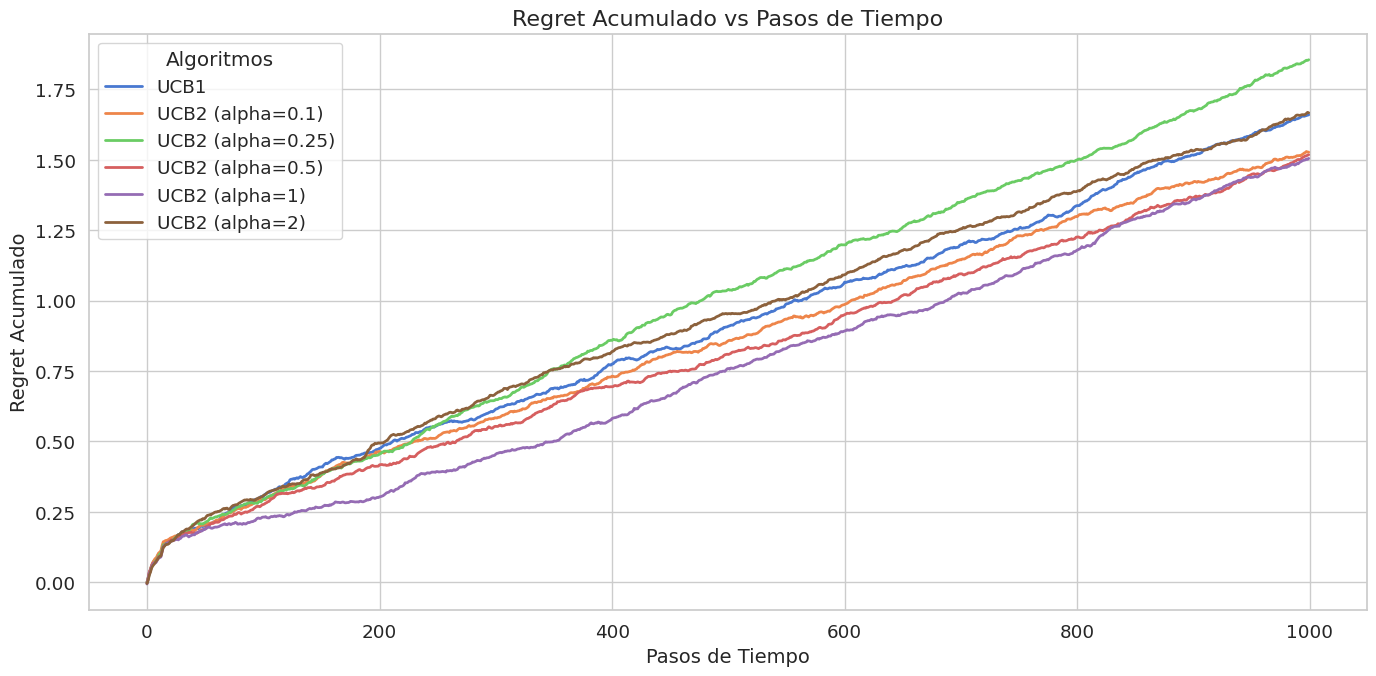

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

1. **Comportamiento general**
  * En general, se aprecia que el regret acumulado se mantiene relativamente bajo. Pero el resultado empeora ligeramente, antes era cercano al valor 1.4 y ahroa 1.7
  .
2. **Comparación entre UCB1 y UCB2**
  * UCB1 (línea azul) y las variantes de UCB2 exhiben trayectorias bastante similares, sin diferencias muy pronunciadas. Pequeñas variaciones en la pendiente de cada curva pueden indicar momentos en que un algoritmo explora más que otro. Igual que antes, observamos que UCB2 con α = 1 sería el mejor.

  En conjunto, los resultados muestran que UCB1 y las variantes de UCB2 tienen un rendimiento muy similar en términos de regret acumulado.

##### Porcentaje de selección del brazo óptimo

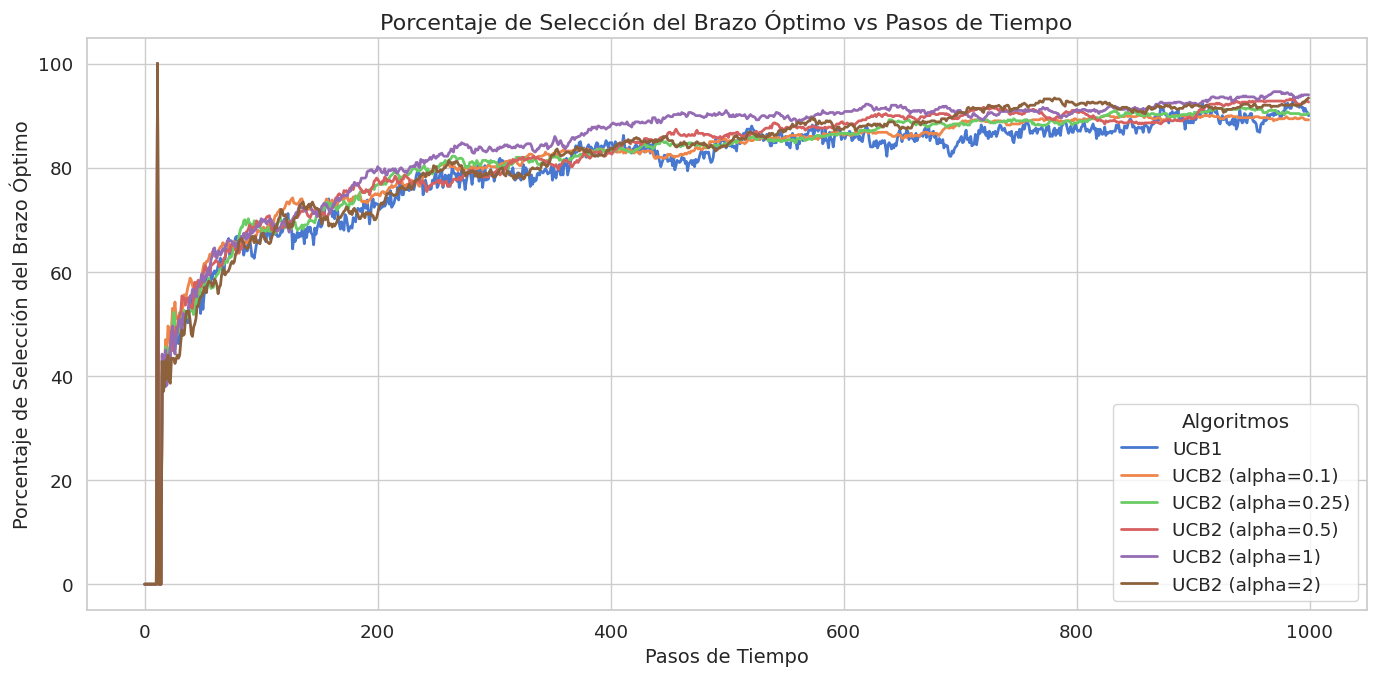

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

La imagen muestra un gráfico de líneas titulado "Porcentaje de selección del brazo óptimo vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

**Análisis del comportamiento**
* Se observa que todas las variantes del algoritmo UCB convergen hacia un porcentaje de selección del brazo óptimo cercano al 90%. Esto indica que todas las estrategias logran identificar y explotar el brazo óptimo con éxito.

* Sin embargo, en el caso de 10 brazos el porcentaje de selección del brazo óptimo era cercano al 100%.

**Conclusión**

* El algoritmo UCB, en todas sus variantes, demuestra ser efectivo para resolver el problema del multi-armed bandit, logrando identificar y explotar el brazo óptimo.
* Según vamos aumentamos el número de brazos el porcetaje de selección del brazo óptimo disminuye.

#### K = 20

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 20  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), UCB2(k=k, alpha=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 20 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

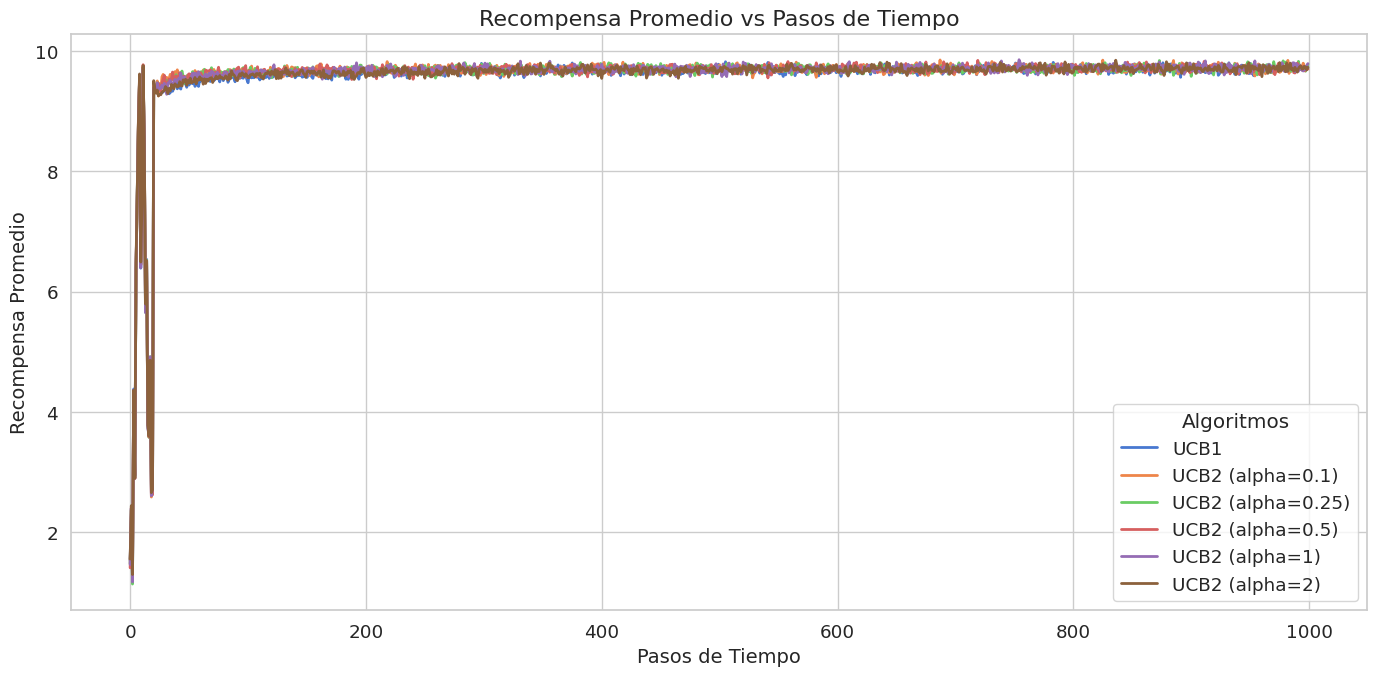

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

**Mayor especio de exploración**
  * Con 20 brazos, el algoritmo necesita explorar un espacio mucho más grande. Esto hace que la convergencia sea más lenta, especialmente en las etapas iniciales del aprendizaje.

**Mayor diicultad para identificar el brazo óptimo**
  * Como aumentamos el número de brazos, a probabilidad de que existan brazos con recompensas similares también aumenta (brazo 9 y 12). Esto puede dificultar la identificación del brazo óptimo y requerir más pasos de tiempo para que el algoritmo pueda distinguirlo claramente.

##### Regret acumulado

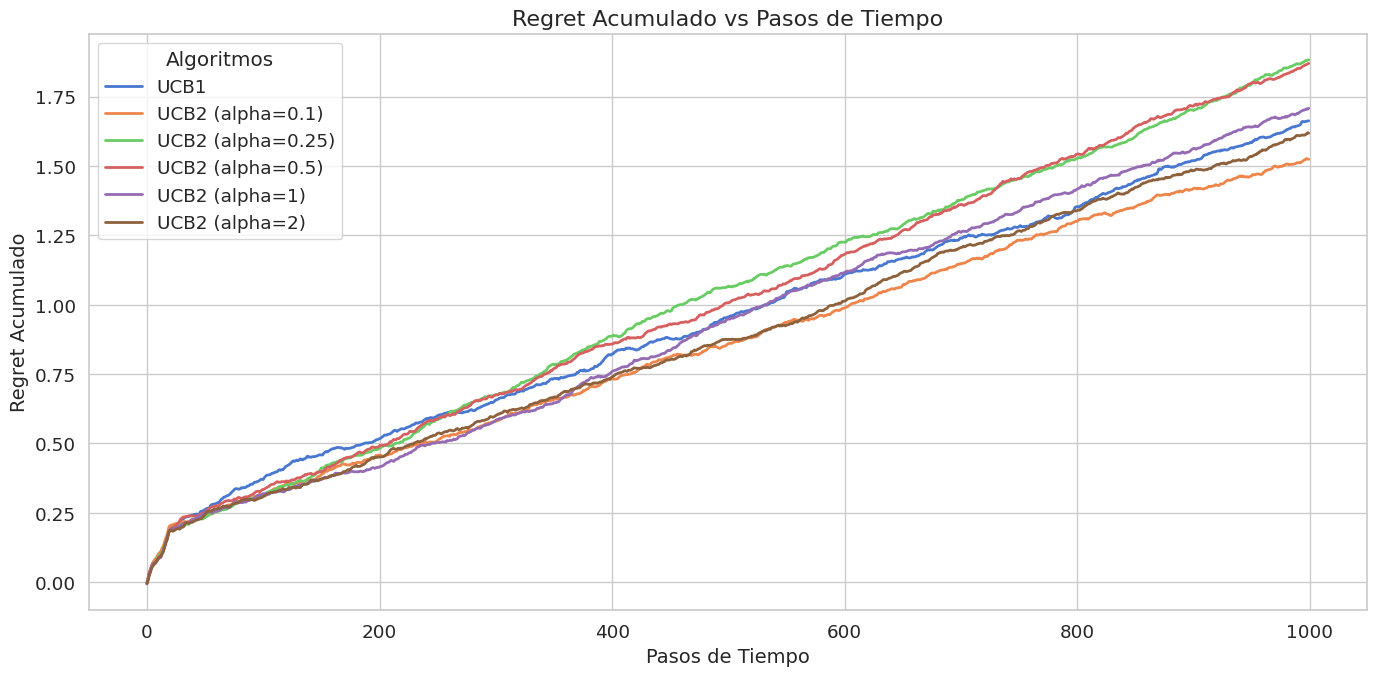

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

**Alphas bajos**
  * Podemos observar como han cambiado las instancias que tenian menor regret acumulado. Hasta ahora el experimento con α = 1 era el que obtenia mejor regret. Sin embargo, ahora vemos como a partir de la iteracion 4 eso cambia. Con α 2 y 0.1 obtienen mejores resultados.

  

##### Porcentaje de selección del brazo óptimo

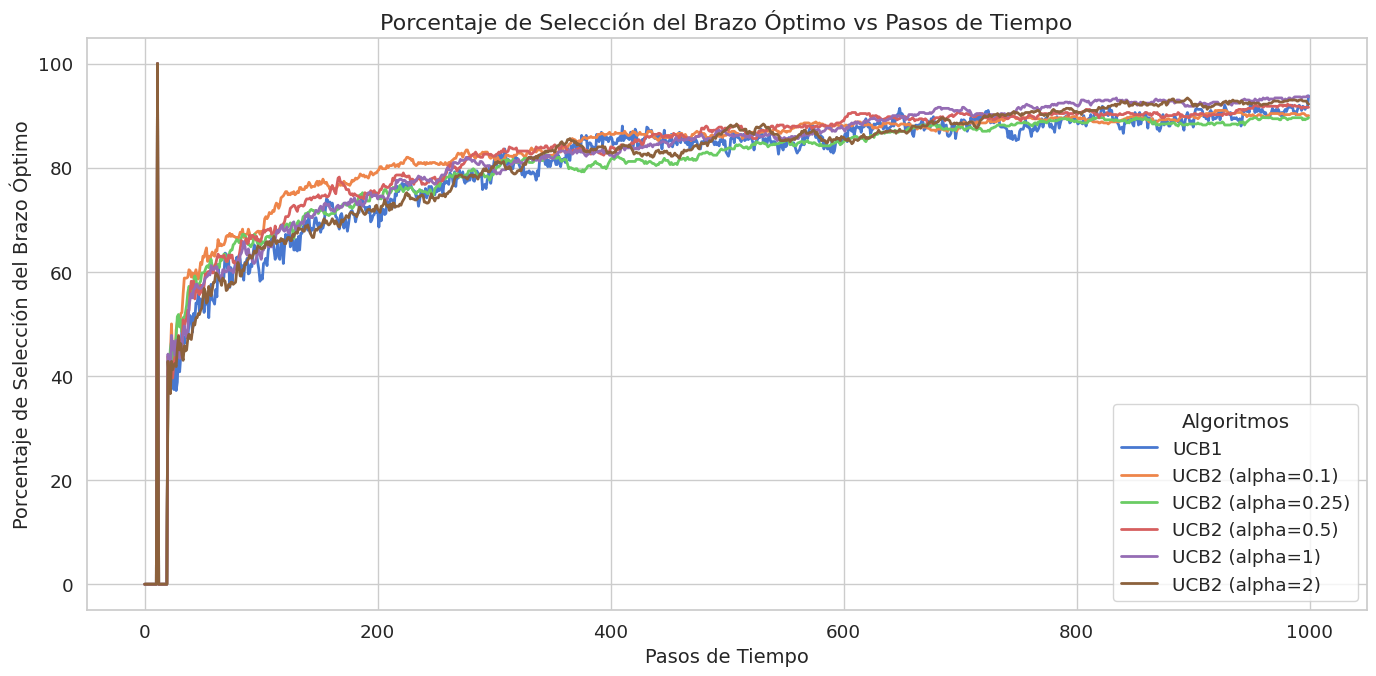

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

La imagen muestra un gráfico de líneas titulado "Porcentaje de selección del brazo óptimo vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

**Velocidad de Convergencia**
  * Las variantes de UCB2 con valores de alpha más bajos muestran una convergencia ligeramente más lenta.

**Exploración vs. Explotación**
  * Al inicio del experimento, se observa una fase de exploración donde los algoritmos prueban diferentes brazos. Con el tiempo, se produce una transición hacia la explotación, donde los algoritmos se centran en seleccionar el brazo óptimo.

#### K = 30

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 30  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), UCB2(k=k, alpha=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 30 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=2.26, sigma=1.0), ArmNormal(mu=5.1, sigma=1.0), ArmNormal(mu=6.33, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=2.8, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=3.63, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=4.3, sigma=1.0), ArmNormal(mu=5.63, sigma=1.0), ArmNormal(mu=6.47, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0), ArmNormal(mu=1.42, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

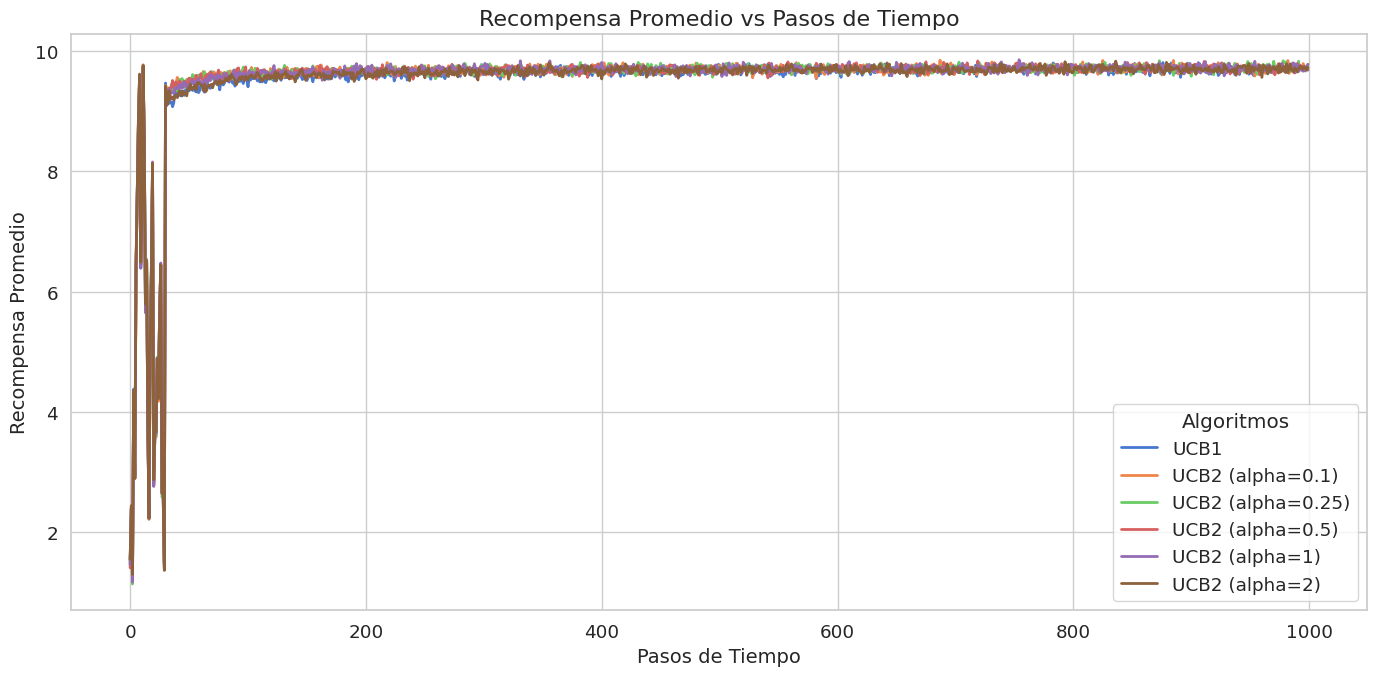

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB (Upper Confidence Bound) en un entorno de multi-armed bandit con 30 brazos.

* **Crecimiento de la recompensa promedio**
  * Todas las variantes de UCB muestran un crecimiento rápido en la recompensa promedio durante los primeros pasos de tiempo, lo que indica una fase de exploración activa.
  * Después de la fase inicial, todas las variantes convergen hacia un nivel de recompensa promedio alto y estable, lo que sugiere que han logrado identificar los brazos óptimos del bandit.
  * Todas las variantes logran un rendimiento muy similar, lo que indica que todas logran encontrar una buena solución al problema.

  

##### Regret acumulado

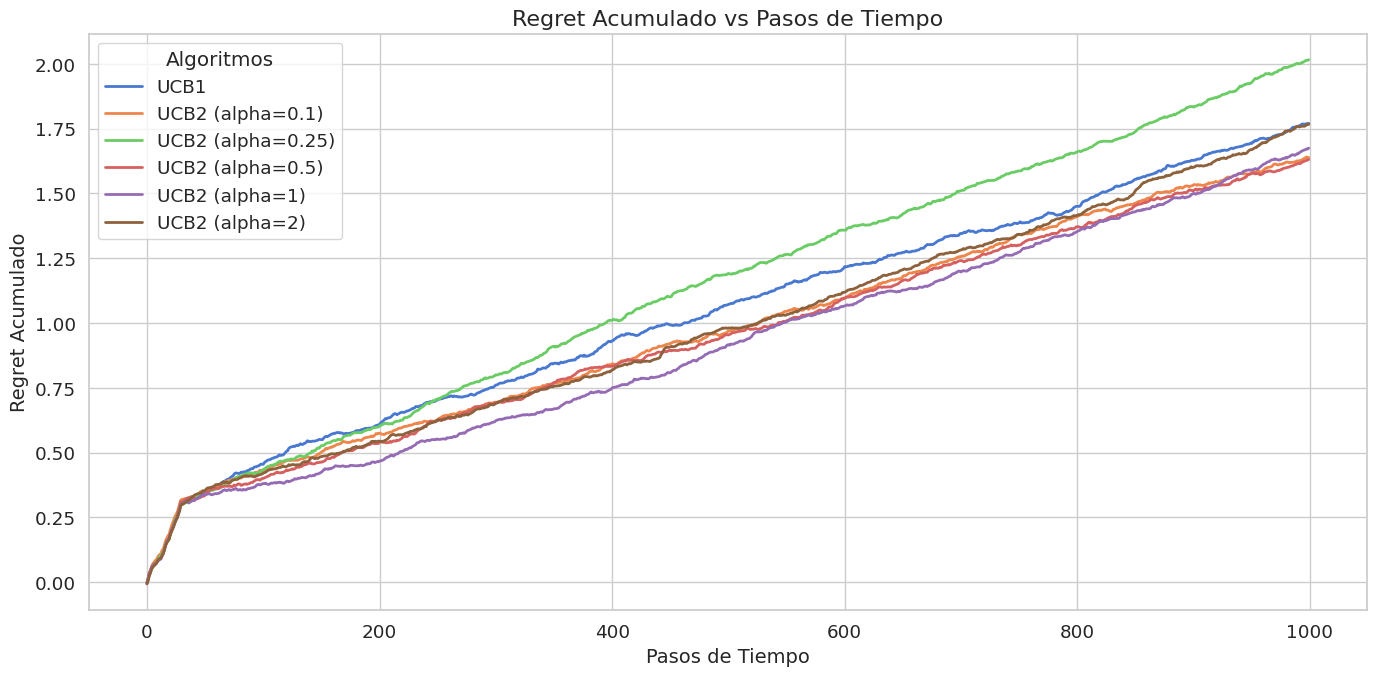

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

* **Crecimiento del Regret Acumulado**
  * Todas las variantes de UCB muestran un crecimiento inicial rápido en el regret acumulado durante los primeros pasos de tiempo, lo que indica una fase de exploración activa.
  * Después de la fase inicial, el crecimiento del regret acumulado se vuelve más lento y lineal, lo que sugiere que los algoritmos han logrado identificar los brazos óptimos del bandit y están explotando esa información.
  * La variante de UCB2 con alpha moderado (1) muestra el menor regret acumulado durante la mayor parte de la ejecución.
  * Al final, podemos ver como las variantes de UCB2 con alpha bajo (0.5, 0.1) terminan por abajo de las demás.


##### Porcentaje de selección del brazo óptimo

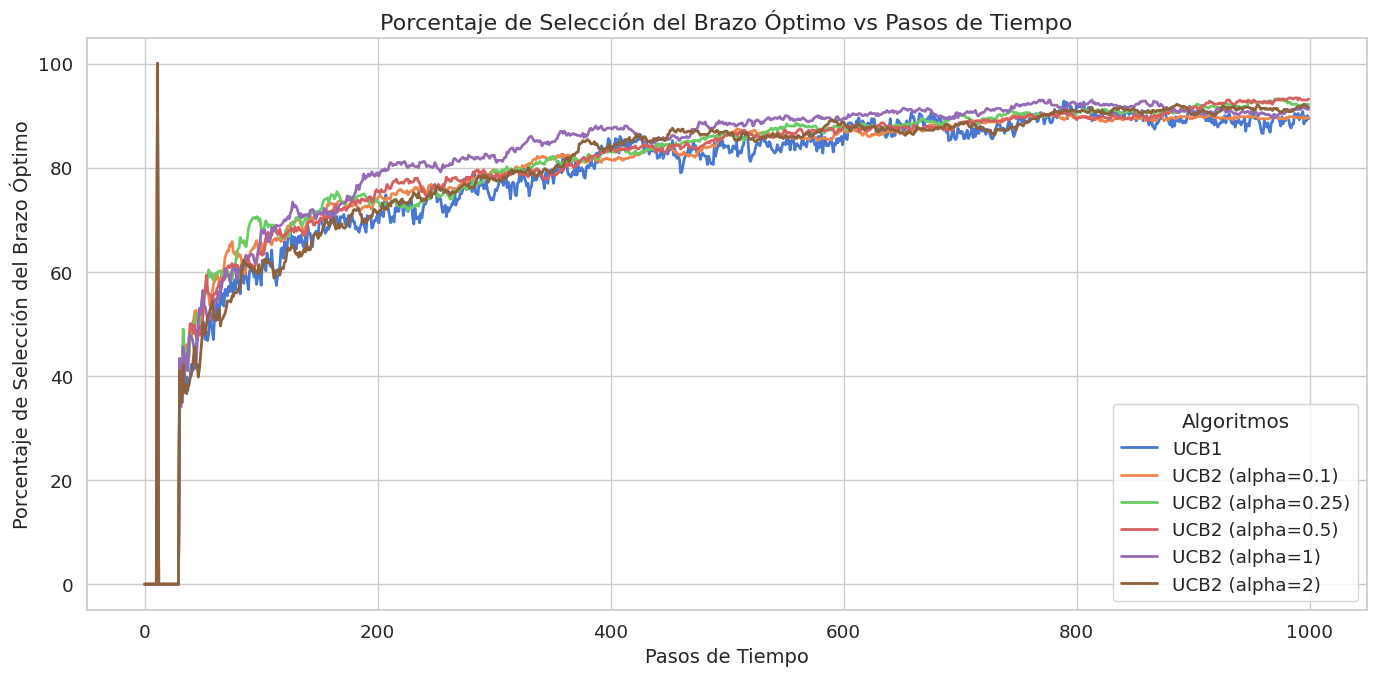

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

La imagen muestra un gráfico de líneas titulado "Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

* **Crecimiento del Porcentaje de Selección del Brazo Óptimo**
   * Todas las variantes de UCB muestran un crecimiento rápido en el porcentaje de selección del brazo óptimo durante los primeros pasos de tiempo, lo que indica una fase de exploración activa.

   * Se observa que UCB1 y las variantes de UCB2 con alpha bajo (0.1, 0.25 y 0.5) alcanzan un porcentaje de selección del brazo óptimo similar.

## Comparación entre distribuciones
El paso final es analizar su comportamiento ante diferentes distribuciones de recompensa.

No se va a analizar la distribución normal ya que saldrían las mismas graficas que obtenidas en el apartado "Comparación entre algoritmos".

#### Distribución binomial

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k, 10)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), UCB2(k=k, alpha=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.4), ArmBinomial(n=10, p=0.86), ArmBinomial(n=10, p=0.22), ArmBinomial(n=10, p=0.69), ArmBinomial(n=10, p=0.58), ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.79), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.12), ArmBinomial(n=10, p=0.88)
Optimal arm: 10 with expected reward=8.8


##### Recompensa promedio

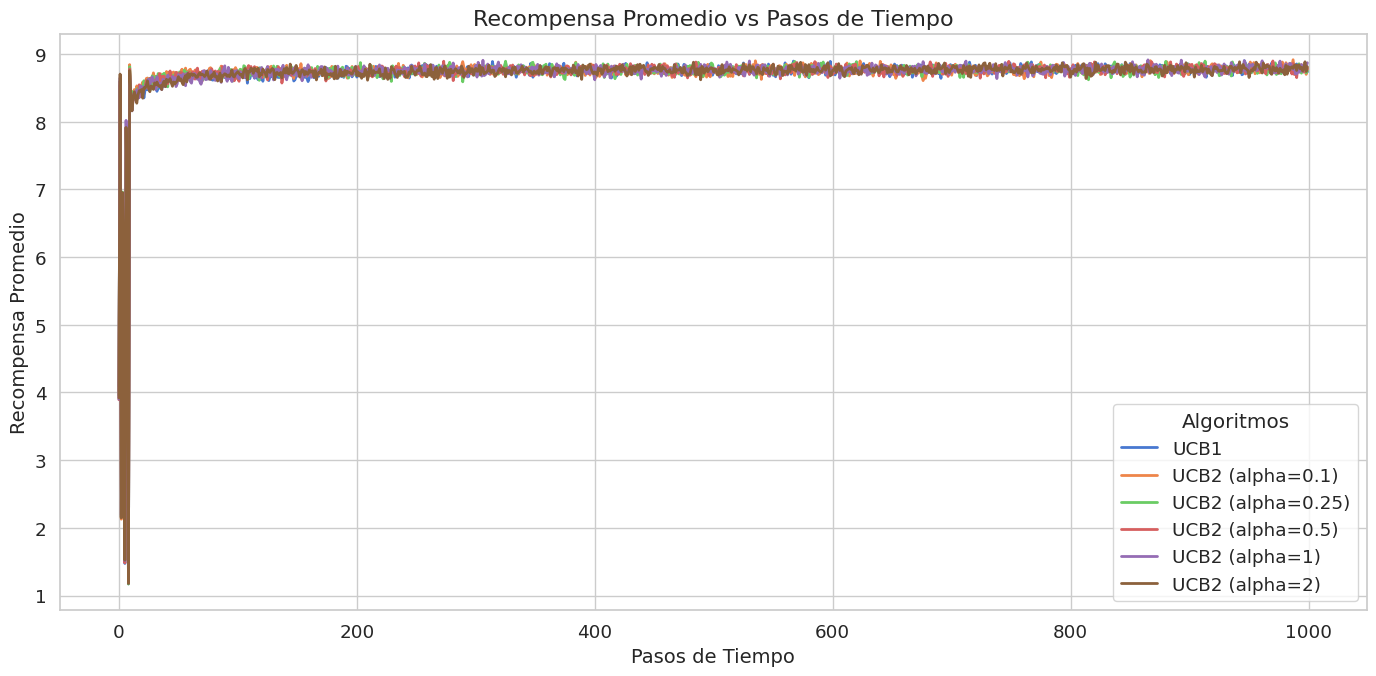

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

* **Análisis de la Imagen**

  * Observamos que todas las variantes de UCB convergen a un valor de recompensa promedio cercano a 8.7-8.8. Esto sugiere que encuentrar el brazo óptimo, ya que el brazo óptimo tiene una recompensa esperada de 8,8.
  * Al inicio, todas las variantes de UCB muestran una fluctuación significativa en la recompensa promedio. Esto se debe a la fase de exploración.
  * Todas las variantes de UCB muestran un rendimiento similar, lo que sugiere que todas logran estimar p con precisión y converger al brazo óptimo.

En este gráfico no podemos ver una diferencia entre la distribución normal y la binomial.

##### Regret acumulado

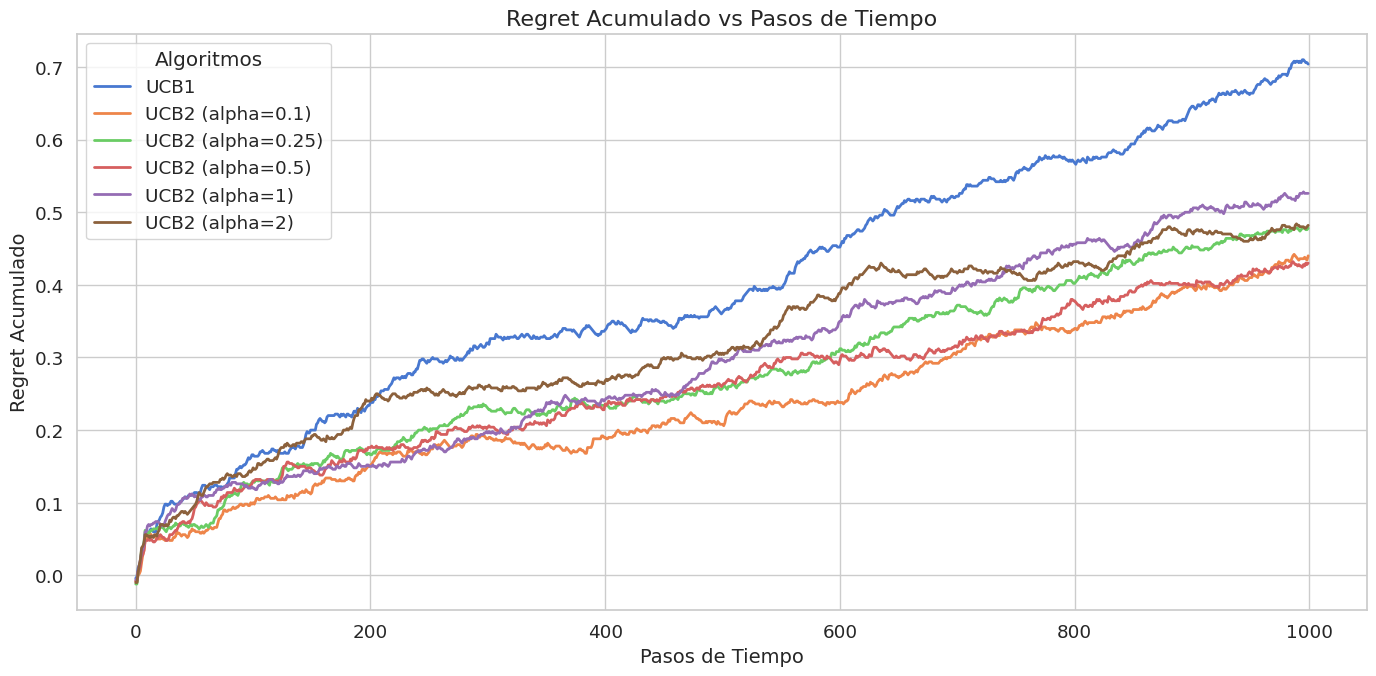

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

**Análisis**
  * Todas las variantes de UCB muestran un crecimiento inicial rápido en el regret acumulado durante los primeros pasos de tiempo. Esto se debe a la fase de exploración.
  * Se observa que las variantes de UCB2 con alpha bajo (0.1, 0.25 y 0.5) tienen un regret acumulado similar y más bajo en comparación con las variantes de UCB2 con alpha más alto (1 y 2). Esto sugiere que las variantes con alpha bajo logran converger al brazo óptimo más rápido y con mayor precisión en el contexto binomial.

**Conclusiones**
  * Las variantes de UCB2 con alpha bajo muestran un mejor desempeño en términos de regret acumulado, lo que indica que logran minimizar la pérdida de recompensa en el contexto binomial.

Aquí si que podemos apreciar diferencias con la distribución normal. Antes teniamos que la variante con alpha igual a 1 era la que siempre obtenia un regret acumulado más bajo. Sin embargo, aquí podemos ver como las variantes con alphas bajos obtienen mejores resultados.

##### Porcentaje de selección del brazo óptimo

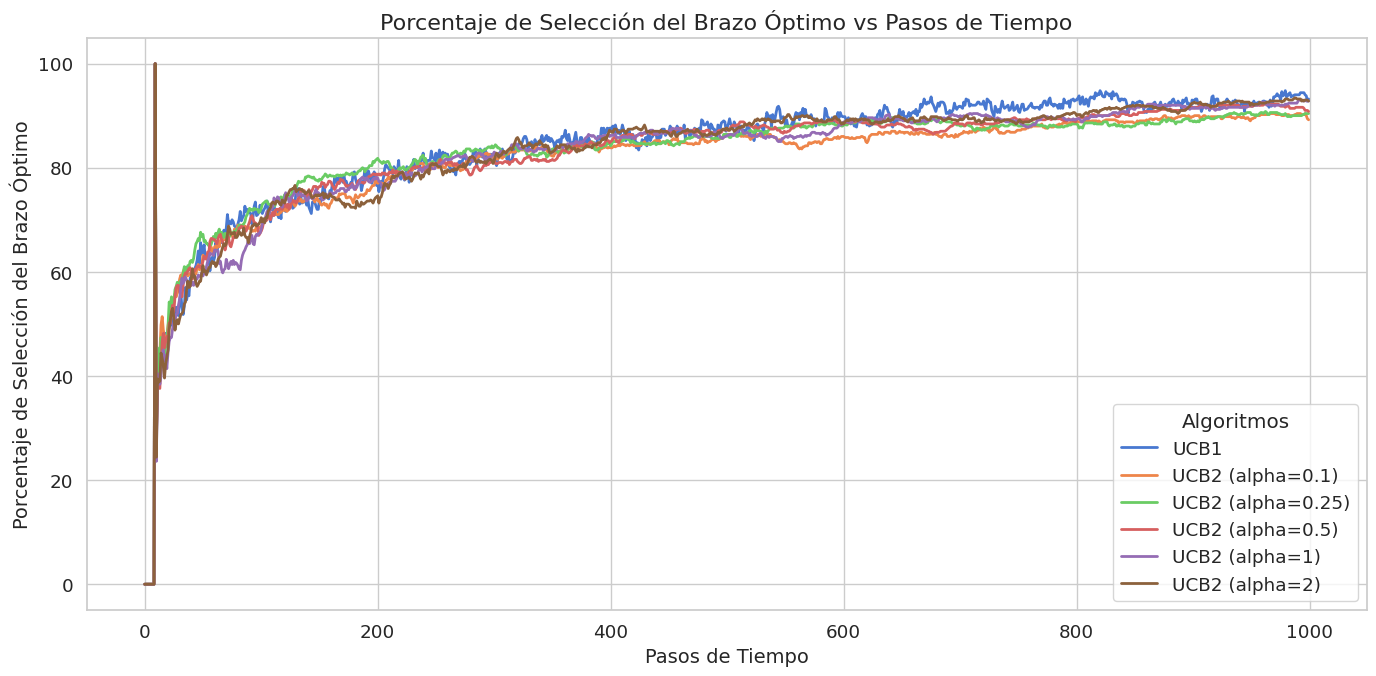

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

La imagen muestra un gráfico de líneas titulado "Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

**Interpretación**
  * Se observa que las variantes de UCB2 con alpha bajo (0.1, 0.25 y 0.5) alcanzan un porcentaje de selección del brazo óptimo similar y más alto en comparación con las variantes de UCB2 con alpha más alto (1 y 2).
  * También podemos observar que UCB1, por momentos, es el que tiene el porcentaje de selección más alto. Esto lo podemos correlacionar con los momentos en los que en la gráfica anterior se ve un descenso del regret acumulado.

#### Distribución de Bernoulli

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), UCB2(k=k, alpha=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.4), ArmBernoulli(p=0.86), ArmBernoulli(p=0.22), ArmBernoulli(p=0.69), ArmBernoulli(p=0.58), ArmBernoulli(p=0.15), ArmBernoulli(p=0.79), ArmBernoulli(p=0.67), ArmBernoulli(p=0.12), ArmBernoulli(p=0.88)
Optimal arm: 10 with expected reward=0.88


##### Recompensa promedio

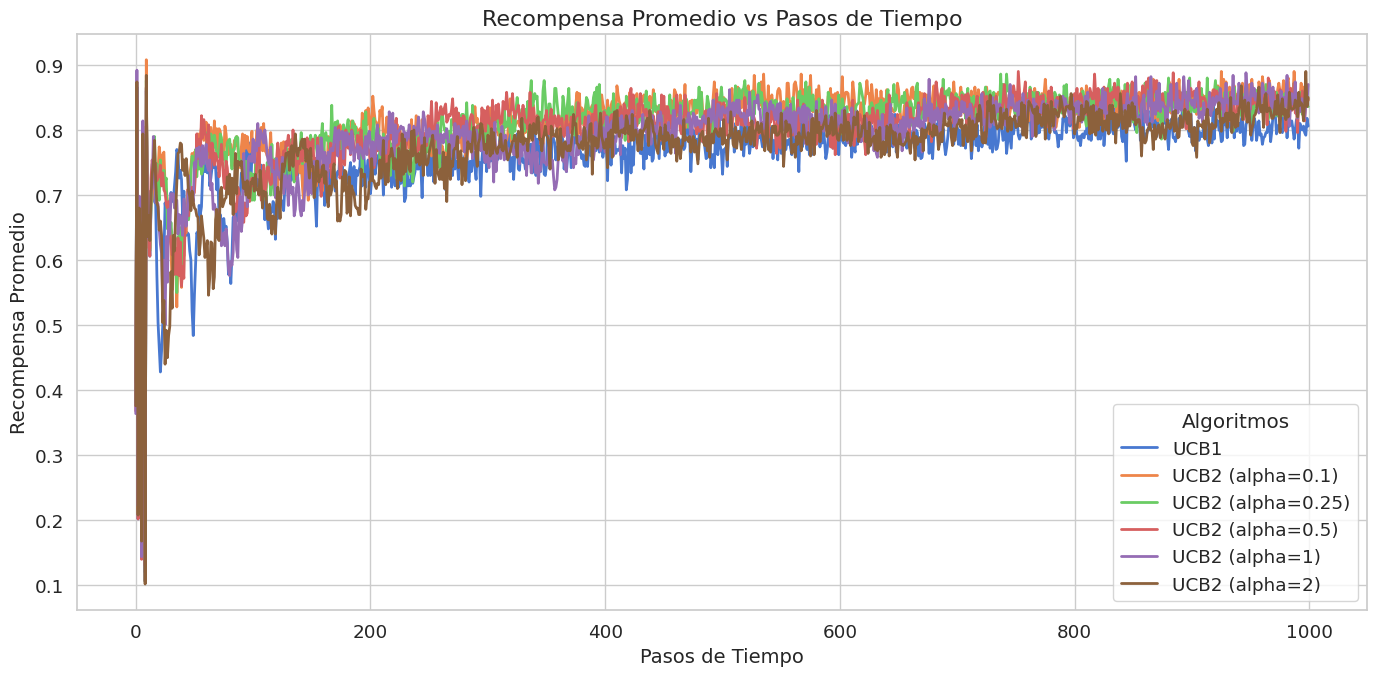

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa promedio vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

* **Análisis**
  * Todas las variantes de UCB muestran una fluctuación significativa en la recompensa promedio.
  * Todas las variantes de UCB muestran un rendimiento similar, pero podemos observar que las variantes de UCB2 con alpha bajo son las que obtienen los mejores resultado.

Los algoritmos han identificado el brazo óptimo y están explotando esa información. Pero parece ser que con la distribución binomial y de Bernoulli las variantes con alpha bajo obtienen resultados ligeramente superiores.

##### Regret acumulado

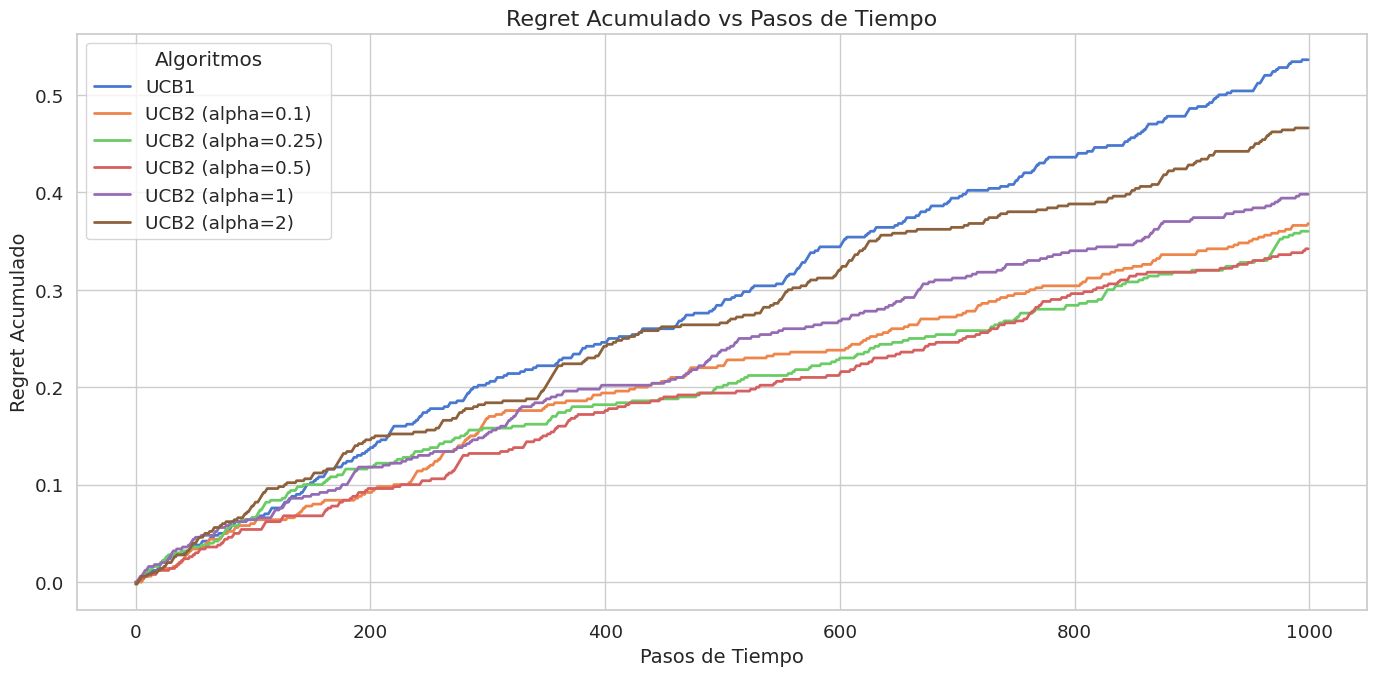

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

**Análisis**
  * Se observa que las variantes de UCB2 con alpha bajo (0.1, 0.25 y 0.5) tienen un regret acumulado similar y más bajo en comparación con las variantes de UCB2 con alpha más alto (1 y 2). Esto sugiere que las variantes con alpha bajo logran converger al brazo óptimo más rápido y con mayor precisión en el contexto de Bernoulli.

**Conclusiones**
  * UCB2 con alpha bajo es más eficiente: las variantes de UCB2 con alpha bajo muestran un mejor desempeño en términos de regret acumulado, lo que indica que logran minimizar la pérdida de recompensa en el contexto de Bernoulli.
  * Estos resultados son consistentes con el gráfico de recompensa promedio, donde vimos que todas las variantes convergieron a un valor similar, pero las variantes con alpha bajo lo hicieron más rápido y con menos fluctuaciones.


##### Porcentaje de selección del brazo óptimo

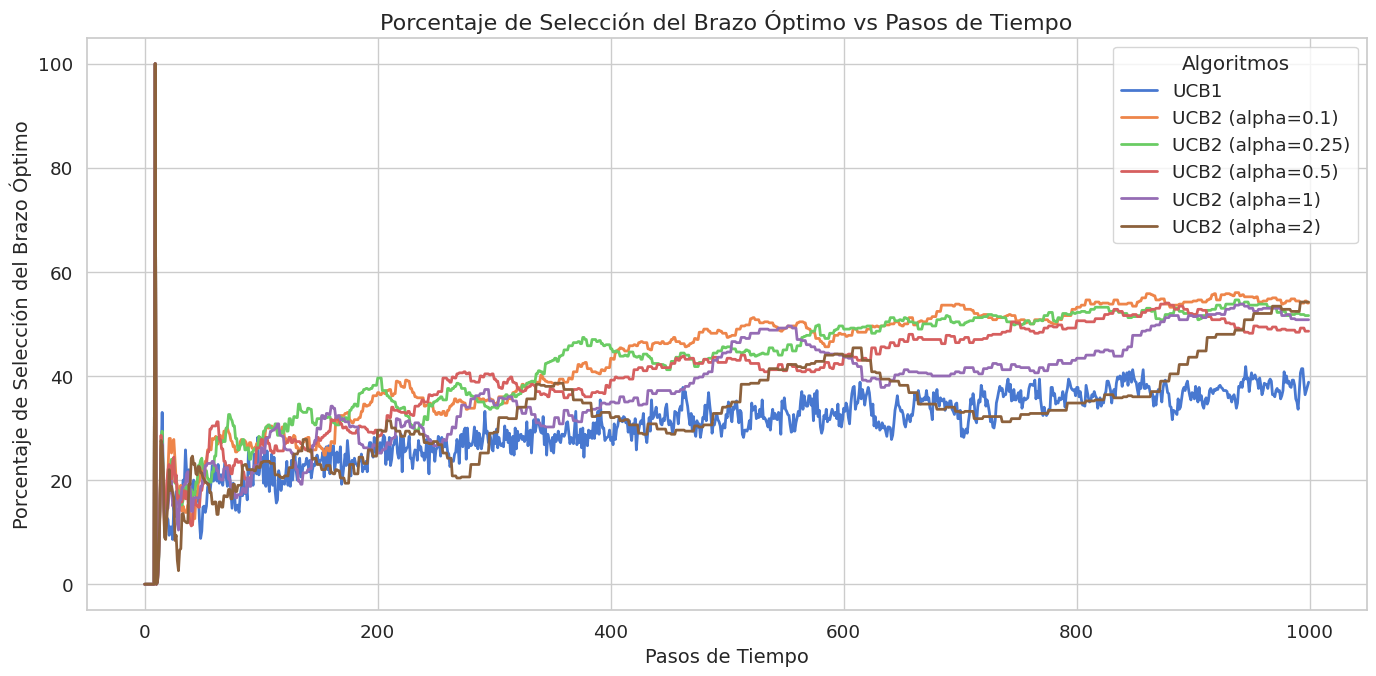

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

La imagen muestra un gráfico de líneas titulado "Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

**Diferencias entre variantes**
  * Las variantes de UCB2 con alpha bajo (0.1, 0.25 y 0.5) alcanzan un porcentaje de selección del brazo óptimo similar y más alto en comparación con las variantes de UCB2 con alpha más alto (1 y 2).
  * UCB1 se mantiene durante todos los pasos de tiempo como la opción que selecciona el brazo óptimo menos veces.
  * Las variantes con alpha alto tienen una gran variación a lo largo de la ejecución. Podemos ver como UCB2 con alpha igual a 2 tiene como una forma senoidal, donde por momentos es peor que UCB1 y en otro momento está igual que las mejores variantes.